About Dataset
Context

This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.
Content

The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid: A unique number that identifies each player.
- version: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- sum_gamerounds: the number of game rounds played by the player during the first 14 days after install.
- retention_1: Did the player come back and play 1 day after installing?
- retention_7: Did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either. 

Acknowledgements

This dataset is taken from DataCamp
Cookie Cat is a hugely popular mobile puzzle game developed by Tactile Entertainment

Thanks to them for this dataset! 😻 

Hypothesis:
For Retention Rate:
H0: No difference in retention rates between gate_30 and gate_40
H1: There is a difference in retention rates

For gamerounds:
H0: No difference in game rounds between gate_30 and gate_40
H1: There is a difference in game rounds

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Dataset Overview
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


+ retention_1 and retention_7 seem to be in correct format

In [4]:
df.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [5]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

+ No null value

In [6]:
df.groupby('version')['userid'].nunique()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

+ This represents a 49.6/50.4 split. Acceptable ratio.

<Axes: xlabel='version'>

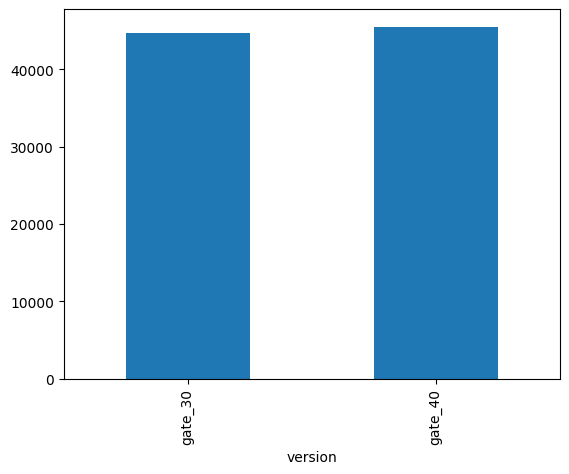

In [7]:
df.groupby('version')['userid'].nunique().plot(kind='bar')


In [8]:
# Lets check the gamerounds metric
df.groupby(['version'])["sum_gamerounds"].value_counts().unstack(fill_value=0)

sum_gamerounds,0,1,2,3,4,5,6,7,8,9,...,2015,2063,2124,2156,2251,2294,2438,2640,2961,49854
version,,,,,,,,,,,,,,,,,,,,,
gate_30,1937,2749,2198,1899,1831,1442,1420,1199,1162,998,...,0,0,0,1,1,0,1,0,1,1
gate_40,2057,2789,2408,2059,1798,1550,1441,1180,1105,1015,...,1,1,1,0,0,1,0,1,0,0


+ There are outliners in this metric. I would remove any value over 99% percentile.

In [9]:
q99 = df['sum_gamerounds'].quantile(0.99)
df_cleaned = df[df['sum_gamerounds'] <= q99]
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89291 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          89291 non-null  int64 
 1   version         89291 non-null  object
 2   sum_gamerounds  89291 non-null  int64 
 3   retention_1     89291 non-null  bool  
 4   retention_7     89291 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.9+ MB


In [10]:
game_rounds = df_cleaned.groupby(['version'])["sum_gamerounds"].value_counts().unstack(fill_value=0)

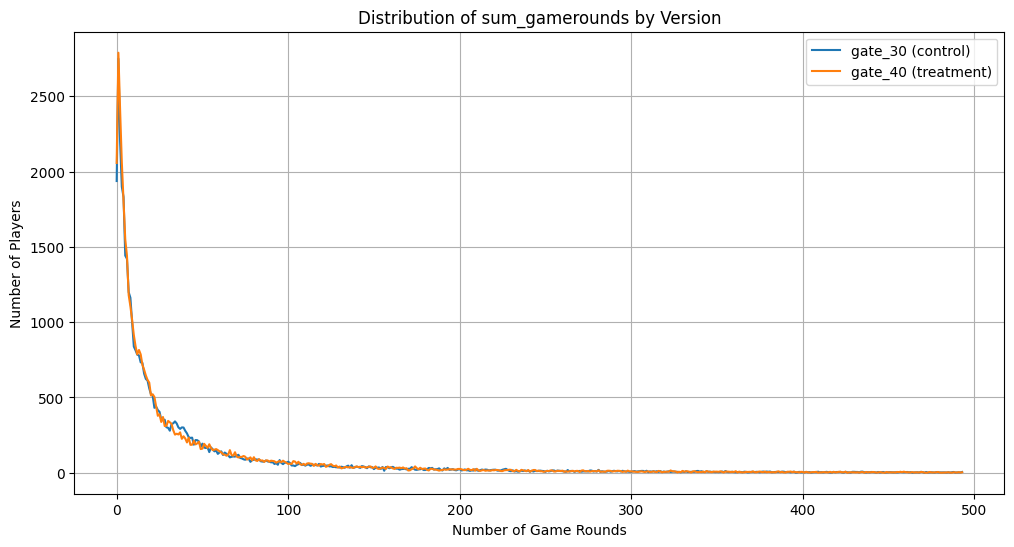

In [11]:
plt.figure(figsize=(12,6))
plt.plot(game_rounds.columns, game_rounds.loc['gate_30'], label='gate_30 (control)')
plt.plot(game_rounds.columns, game_rounds.loc['gate_40'], label='gate_40 (treatment)')

plt.xlabel('Number of Game Rounds')
plt.ylabel('Number of Players')
plt.title('Distribution of sum_gamerounds by Version')
plt.legend()
plt.grid(True)
plt.show()

+ After removing outliners, the distribution of game rounds between 2 version are identicle.
+ However in this graph, I noticed there is a portion of the population installed the game but never play a single round!

In [12]:
df_cleaned[df_cleaned['sum_gamerounds']==0].groupby('version')['userid'].count()

version
gate_30    1937
gate_40    2057
Name: userid, dtype: int64

+ 3994 players out of 89291 (4.5%) had installed the game but never play a single round.
This could be because of:
+ They were busy with other tasks
+ The game lost its appeal after installation
+ Technical issues

In [13]:
# Retention overview
crosstable = df_cleaned.groupby('version').agg({'userid':'count','retention_1':'mean','retention_7':'mean','sum_gamerounds':'sum'})
crosstable

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44254,0.442920,0.182537,1976494
gate_40,45037,0.436907,0.174190,1999480


Based on this table, in the gate_40 group:
+ There is a slight decrease in retention_1 (down to 44.22% frp, 44.81%)
+ There is a slight decrease in retention_7 (down to 18.2% from 19.02%)
+ This also cause a slight decrease in gamerounds
Since retention are categories, I would perform a chi-square test to determind if the drop in retention is significant for both retention_1 and retention_7

In [14]:
t1 = pd.crosstab(df_cleaned['version'],df_cleaned['retention_1'])
chi2, p_chi, dof, expected = stats.chi2_contingency(t1)
print(f"Chi-square p-value: {p_chi:.10f}")
print(f"Chi statistic: {chi2:.2f}")

Chi-square p-value: 0.0713738820
Chi statistic: 3.25


In [15]:
t2 = pd.crosstab(df_cleaned['version'],df_cleaned['retention_7'])
chi2, p_chi, dof, expected = stats.chi2_contingency(t2)
print(f"Chi-square p-value: {p_chi:.10f}")
print(f"Chi statistic: {chi2:.2f}")

Chi-square p-value: 0.0011576307
Chi statistic: 10.56


+ For sum_gamerounds, this is a continuos variable and sensitive to skewness even after removing the 99% percentile. I would take the mannwhitneyu test for this metric

In [16]:
from scipy.stats import mannwhitneyu

In [17]:
group_30 = df_cleaned[df_cleaned['version']=='gate_30']['sum_gamerounds']
group_40 = df_cleaned[df_cleaned['version']=='gate_40']['sum_gamerounds']

In [18]:
stat, p_mw = mannwhitneyu( group_30,group_40, alternative='two-sided')
print(f"Mann-Whitney U p-value: {p_mw:.10f}")

Mann-Whitney U p-value: 0.0478900069


From the test:
+ sum_gamerounds p-value is less than 0.05, there IS a statistically significant difference between group_30 and group_40 in gamerounds
+ retention_1 p-value is higher than 0.05, there is NO statistically significant difference between group_30 and group_40 in day 1 retention rate
+ retention_7 p-value is less than 0.05, there IS a statistically significant difference between group_30 and group_40 in day 7 retention rate

CONCLUSION:
+ By increasing the game difficulty from level 30 to level 40. There is a drop in retention rate and gamerounds after 7 days.
SUGGESTION:
+ We should not move the difficulty suddenly from level 30 to level 40.
+ We could look at other metric like ingame purchase to further evaluate the changes.
+ There is a 4.5% of the player base installed but did not play any round. Perhap we could reach out to this group to figure out the reason they did not continue.